In [ ]:
#!nvidia-smi

In [ ]:
#%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=0

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

In [2]:
mnist = input_data.read_data_sets("../data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


In [3]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

In [5]:
is_train = tf.placeholder(tf.bool)

In [6]:
conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3],
                        padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                        padding="SAME", strides=2)
bn1 = tf.layers.batch_normalization(pool1, training=is_train)
#drop1 = tf.layers.dropout(inputs=pool1, rate=0.3, training=is_train)

conv2 = tf.layers.conv2d(inputs=bn1, filters=64, kernel_size=[3, 3],
                        padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                        padding="SAME", strides=2)
bn2 = tf.layers.batch_normalization(pool2, training=is_train)
#drop2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=is_train)

conv3 = tf.layers.conv2d(inputs=bn2, filters=128, kernel_size=[3, 3],
                        padding="SAME", activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                        padding="SAME", strides=2)
bn3 = tf.layers.batch_normalization(pool3, training=is_train)
#drop3 = tf.layers.dropout(inputs=pool3, rate=0.3, training=is_train)

In [7]:
flat3 = tf.contrib.layers.flatten(bn3)
dense4 = tf.layers.dense(inputs=flat3, units=625, activation=tf.nn.relu)
bn4 = tf.layers.batch_normalization(dense4, training=is_train)
#drop4 = tf.layers.dropout(inputs=dense4, rate=0.5, training=is_train)

logits = tf.layers.dense(inputs=bn4, units=10)

In [8]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
# initialize
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(tf.global_variables_initializer())

In [11]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, is_train: True}
        #feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 0.086736064
Epoch: 0002 cost = 0.032807603
Epoch: 0003 cost = 0.022384286
Epoch: 0004 cost = 0.016776653
Epoch: 0005 cost = 0.015341550
Epoch: 0006 cost = 0.013965392
Epoch: 0007 cost = 0.011509062
Epoch: 0008 cost = 0.009610090
Epoch: 0009 cost = 0.009850169
Epoch: 0010 cost = 0.007635086
Epoch: 0011 cost = 0.006665374
Epoch: 0012 cost = 0.006924767
Epoch: 0013 cost = 0.007224435
Epoch: 0014 cost = 0.005264172
Epoch: 0015 cost = 0.004874538
Learning Finished!


In [12]:
def evaluate(X_sample, y_sample, batch_size=100):
    """Run a minibatch accuracy op"""

    N = X_sample.shape[0]
    correct_sample = 0

    for i in range(0, N, batch_size):
        X_batch = X_sample[i: i + batch_size]
        y_batch = y_sample[i: i + batch_size]
        N_batch = X_batch.shape[0]

        feed = {
            X: X_batch,
            Y: y_batch,
            is_train: False
        }

        correct_sample += sess.run(accuracy, feed_dict=feed) * N_batch

    return correct_sample / N

print("\nAccuracy Evaluates")
print("-------------------------------")
print('Train Accuracy:', '{:.5f}'.format(evaluate(mnist.train.images, mnist.train.labels)))
print('Test Accuracy:', '{:.5f}'.format(evaluate(mnist.test.images, mnist.test.labels)))


Accuracy Evaluates
-------------------------------
Train Accuracy: 0.99802
Test Accuracy: 0.99180


In [13]:
# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], is_train: False}))
    #tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1.}))

Label:  [6]
Prediction:  [6]


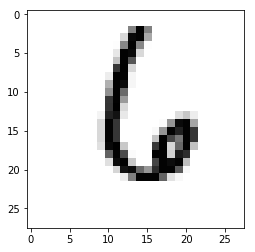

In [14]:
plt.imshow(mnist.test.images[r:r + 1].
          reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

In [15]:
sess.close()